# Crime Data Analysis

- Your analysis here
  
---

In [1]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import hvplot.pandas

# Files to Load
data_2010_2019 = Path("Crime_Data_from_2010_to_2019 (1).csv")
data_2020_2023 = Path("Crime_Data_from_2020_to_Present_20231016.csv")

# Read data(2010-2019) and data (2020- present)Data File and store into Pandas DataFrames
pre_covid_data = pd.read_csv(data_2010_2019)
post_covid_data = pd.read_csv(data_2020_2023)

# Combine the data into a single dataset.  
Data_complete = pd.concat([pre_covid_data, post_covid_data], ignore_index=True)
Data_complete.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,AREA
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13.0,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695,NaN
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14.0,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,NaN
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13.0,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524,NaN
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6.0,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,NaN
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1.0,Central,176,1,122,"RAPE, ATTEMPTED",...,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488,NaN


Data Cleaning


In [2]:
# Create a Year column from the dataframe
Data_complete['Crime Year'] = pd.to_datetime(Data_complete['Date Rptd']).dt.year

C:\Users\dcase\AppData\Local\Temp\ipykernel_34340\975316320.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Data_complete['Crime Year'] = pd.to_datetime(Data_complete['Date Rptd']).dt.year


In [3]:
# Remove unused columns
Data_complete.drop(Data_complete.columns[[1, 2, 3, 4, 6, 7, 10, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,28]], axis=1, inplace=True)

In [5]:
# Remove NaN entries
Data_complete = Data_complete.dropna()
# Clean data for duplicate crime records
Data_complete = Data_complete.drop_duplicates(subset=['DR_NO'])
# Remove unrecorded victim age data
Data_complete = Data_complete[Data_complete['Vict Age'] > 0]

In [6]:
# Change the name of the columns to complete the data cleaningggggggggggggggggg
Data_complete.rename(columns={
                    'DR_NO':'DR Number',
                    'Crime Year': 'Crime Year',
                    'AREA NAME': 'Area Name',
                    'Crm Cd': 'Crime Code',
                    'Crm Cd Desc':'Type of Crime',
                    'Vict Age': 'Victim Age',
                    'Vict Sex': 'Victim Gender',
                    'Vict Descent': 'Victim Ethnicity',
                    'Premis Desc': 'Scene of Crime',
                    'LAT': 'Latitude',
                    'LON': 'Longitude'
                    
},inplace= True)

# Remove coordinates outside of Los Angeles
Data_complete = Data_complete[(Data_complete['Longitude'] < -108) & (Data_complete['Longitude'] > -128)]
Data_complete = Data_complete[(Data_complete['Latitude'] < 44) & (Data_complete['Latitude'] > 24)]

Data_complete.head()

,DR Number,Area Name,Crime Code,Type of Crime,Victim Age,Victim Gender,Victim Ethnicity,Scene of Crime,Latitude,Longitude,Crime Year
0,1307355,Newton,900,VIOLATION OF COURT ORDER,48,M,H,SINGLE FAMILY DWELLING,33.9825,-118.2695,2010
3,90631215,Hollywood,900,VIOLATION OF COURT ORDER,47,F,W,STREET,34.1016,-118.3295,2010
4,100100501,Central,122,"RAPE, ATTEMPTED",47,F,H,ALLEY,34.0387,-118.2488,2010
5,100100506,Central,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),23,M,B,DEPARTMENT STORE,34.0480,-118.2577,2010
6,100100508,Central,330,BURGLARY FROM VEHICLE,46,M,H,STREET,34.0389,-118.2643,2010


## Data Analysis

In [7]:
count = len(Data_complete["DR Number"])
print(count)

2326755


In [ ]:
unique_demo = Data_complete["Victim Age"].value_counts()
print(unique_demo)

In [ ]:
unique_demo = Data_complete["Victim Ethnicity"].value_counts()
print(unique_demo)

In [ ]:
unique_demo = Data_complete["Area Name"].value_counts()
print(unique_demo)

## Yearly Summary

In [8]:
# Get the total number of crimes by year
yearly_total = Data_complete["DR Number"].groupby(Data_complete["Crime Year"]).count().reset_index()
yearly_total.rename(columns={"DR Number": "Total Crimes"}, inplace=True)
yearly_total.set_index('Crime Year', inplace=True)
yearly_total

,Total Crimes
Crime Year,
2010,165841
2011,165353
2012,167092
2013,161037
2014,136966
2015,173958
2016,183310
2017,186878
2018,187540


In [9]:
# Create a Summary Statistics table of the total crimes over the years
yearly_sum_stats = yearly_total.describe()
yearly_sum_stats

,Total Crimes
count,14.000000
mean,166196.785714
std,17733.805332
min,130096.000000
25%,159591.000000
50%,166466.500000
75%,180292.500000
max,187540.000000


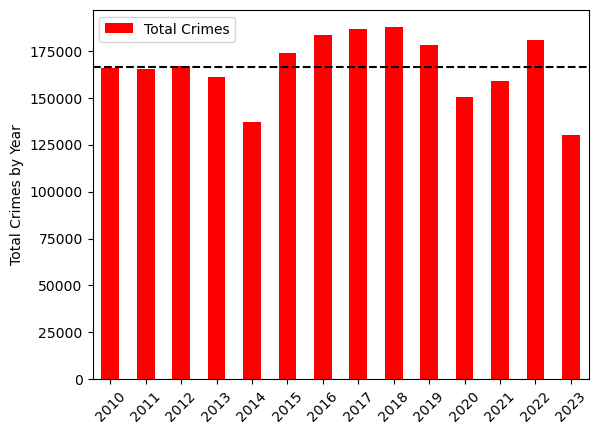

In [20]:
# Bar plot of the total crime count over the length of the dataset
yearly_total_plot = yearly_total
mean_total = yearly_sum_stats.loc['mean', 'Total Crimes']

# Trying to plot the covid years in red
yearly_total_plot.plot(kind="bar", 
                       color=["blue" if year > 2020 else "red" for year in yearly_total.index])

plt.axhline(y=mean_total, color='black', linestyle='--', label=f'Mean: {mean_total}')
plt.xlabel("")
plt.xticks(rotation=45)
plt.ylabel("Total Crimes by Year")
plt.show()

The r-value is: 0.00958871336415062
The p-value is: 0.7391099986438103


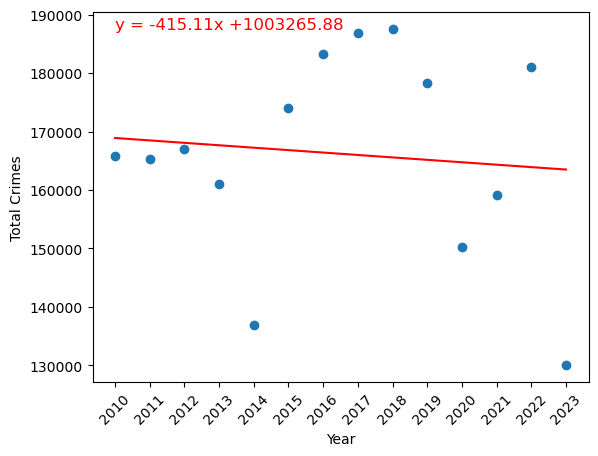

In [21]:
# Linear Regression plot
yearly_total_reg = yearly_total.reset_index()
slope, intercept, rvalue, pvalue, stderr = stats.linregress(yearly_total_reg["Crime Year"], yearly_total_reg["Total Crimes"])
regress = yearly_total_reg["Crime Year"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept, 2))

plt.scatter(yearly_total_reg["Crime Year"], yearly_total_reg["Total Crimes"])
plt.plot(yearly_total_reg["Crime Year"], regress, "r-")
plt.xlabel("Year")
plt.xticks(yearly_total_reg["Crime Year"], rotation=45)
plt.ylabel("Total Crimes")
plt.annotate(line_eq, (min(yearly_total_reg["Crime Year"]), max(yearly_total_reg["Total Crimes"])-1), fontsize=12, color="red")
print(f"The r-value is: {rvalue ** 2}")
print(f"The p-value is: {pvalue}")
plt.show()

In [22]:
# T-Test

# Slice the dataframe to create pre and post covid
pre_covid_slice = yearly_total_reg['Crime Year'][2010:2019]
post_covid_slice = yearly_total_reg['Crime Year'][2020:2023]
crime_ser = yearly_total_reg["Total Crimes"]
pre_covid_slice.crime_ser.mean()
post_covid_slice.crime_ser.mean()

# Perform a t-test to compare the means of the two groups
stats.ttest_ind(pre_covid_slice.crime_ser, post_covid_slice.crime_ser, equal_var=False)



AttributeError: 'Series' object has no attribute 'crime_ser'

In [23]:
# Define function to pull the most common occurring value in each column
def highest_occurance(column):
    return column.value_counts().idxmax()

# Group the data by 'Crime Year' and apply the most_frequent_value function to each column
highest_occurance = Data_complete.groupby('Crime Year').agg({
                    'Area Name': highest_occurance,
                    'Crime Code': highest_occurance,
                    'Type of Crime': highest_occurance,
                    'Victim Age': highest_occurance,
                    'Victim Gender': highest_occurance,
                    'Victim Ethnicity': highest_occurance,
                    'Scene of Crime': highest_occurance
                    }).reset_index()

In [26]:
# Create Yearly Summary table by merging the two new yearly analysis dataframes
yearly_summary_df = pd.merge(yearly_total, highest_occurance, on='Crime Year')
yearly_summary_df.set_index('Crime Year', inplace=True)
yearly_summary_df

,Total Crimes,Area Name,Crime Code,Type of Crime,Victim Age,Victim Gender,Victim Ethnicity,Scene of Crime
Crime Year,,,,,,,,
2010,165841,77th Street,624,BATTERY - SIMPLE ASSAULT,25,F,H,SINGLE FAMILY DWELLING
2011,165353,77th Street,624,BATTERY - SIMPLE ASSAULT,25,F,H,SINGLE FAMILY DWELLING
2012,167092,77th Street,624,BATTERY - SIMPLE ASSAULT,26,F,H,SINGLE FAMILY DWELLING
2013,161037,77th Street,624,BATTERY - SIMPLE ASSAULT,23,F,H,SINGLE FAMILY DWELLING
2014,136966,77th Street,624,BATTERY - SIMPLE ASSAULT,23,F,H,SINGLE FAMILY DWELLING
2015,173958,77th Street,624,BATTERY - SIMPLE ASSAULT,25,M,H,SINGLE FAMILY DWELLING
2016,183310,77th Street,624,BATTERY - SIMPLE ASSAULT,25,F,H,SINGLE FAMILY DWELLING
2017,186878,77th Street,624,BATTERY - SIMPLE ASSAULT,27,M,H,SINGLE FAMILY DWELLING
2018,187540,Southwest,624,BATTERY - SIMPLE ASSAULT,28,M,H,SINGLE FAMILY DWELLING


## Crimes Summary

In [ ]:
Total_crime_count = len(Data_complete['DR Number'])
Total_crime_count

In [ ]:
# Calculate the total number of Crimes 
##Total_crime_count = Data_complete.len['Type of Crime']


# unique kind of the crimes:
#Kind_of_crimes = clean_crime_data.groupby(["Crm Cd Desc","crime_year"], as_index = false).count()

# Pick which highest frequency (5)
#highest_frequency_crime = Kind_of_crimes.sort_values(ascending= False)

# Inside the home and outside the home( COVID people were home)



In [ ]:
#Plot a line graph showing the overall crimes trend change over the years
plot.line

In [ ]:
# Calculate the kind of crimes (e.g different kind of crimes) per year??
#the distribution of crime types over the years
#clean_crime_data.loc(2017)
#df_2017= 
#df_2018
#df_2019
#df_2020
#df_2021
#df_2022
#crime_type



In [ ]:
# Create a dataframe with crime_type and year????
crime_summary = pd.DataFrame({
    

In [ ]:
# Plot a bar plot with multiple columns over the different years for total number of crimes(value count)


In [ ]:
# Plot another histogram for average of pre covid and post covid crimes (Total and one for each crime).

## Area Summary

In [ ]:
#  select all of the different Areas


In [ ]:
# Divide areas into Central, Valley, South, West

In [ ]:
# Calculate the total crimes per area per year
per_area_crime_counts = 

In [ ]:
#calculate crime types per area
# Five highest crimes 

In [ ]:
# Geoplot the area 

In [ ]:
# Make a data frame with Columns for Average crime per area


# Display Data Frame

In [ ]:
# Highest Crime Area(By Total Crimes)

In [ ]:
# Lowest Crime Area (By Total Crime)

In [ ]:
#Bar chart four areas, four years and total number of crimes

In [ ]:
# Identify Hot Spots
#Crime in each area acroos the years

In [ ]:
# Any change in the Hot spots overs the years


### Female Vs Male Victims

In [ ]:
# Generate a pie plot showing the distribution of female versus male victims using Pandas
data = data["Sex"].value_counts()
plt.title("Female vs. Male Victims")
Female_male_data.plot.pie(autopct= "%1.1f%%")
plt.show()

### Victim Race 

# Child Abuse compare over the years

## Change in crime spot

In [ ]:
#Splitting race by groups: Black, White, Hispanics, Asians

In [ ]:
#Splitting premise into 4 categories: Commercial, residential, industrial and outdoors
# using Bins

In [ ]:
#Percentage of increase and decrease in crimes over the years
Total_crime_count groupbyyear (count)

In [ ]:
 #How has crime changed over the years?
 
 Line graphs 